In [49]:
!wget https://www.dl.dropboxusercontent.com/s/lp7f9h74ebwnf97/steam_reviews.csv?dl=0

--2021-10-31 22:14:24--  https://www.dl.dropboxusercontent.com/s/lp7f9h74ebwnf97/steam_reviews.csv?dl=0
Resolving www.dl.dropboxusercontent.com (www.dl.dropboxusercontent.com)... 162.125.5.15, 2620:100:601d:15::a27d:50f
Connecting to www.dl.dropboxusercontent.com (www.dl.dropboxusercontent.com)|162.125.5.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120722076 (115M) [text/csv]
Saving to: ‘steam_reviews.csv?dl=0.1’

steam_reviews.csv?d 100%[===================>] 115.13M  65.4MB/s    in 1.8s    

2021-10-31 22:14:27 (65.4 MB/s) - ‘steam_reviews.csv?dl=0.1’ saved [120722076/120722076]



## Initial EDA

The focus for this dataset is text classification, based on solely two features: `recommendation` and `review`. We will be creating a model that will classify a game review as recommended or not recommended. 
Before we do any sort of model creation, first we will focus on performing exploratory data analysis in order to better understand our data. Some of the observations we will be making consist of:
- The distribution of the recomendation column
- The top words in the reviews column
- The overall number of words
- Average words per review

In [3]:
# trick to wrap text to the viewing window for this notebook
# Ref: https://stackoverflow.com/questions/58890109/line-wrapping-in-collaboratory-google-results
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [176]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read in the data
steam = pd.read_csv("/content/steam_reviews.csv?dl=0")

# Create training and test set to avoid information leakage
steam_train, steam_test = train_test_split(steam, test_size=0.2, random_state=42)


print(f"Total number of instances: {len(steam_train)}")

Total number of instances: 347912


In [51]:
steam_train.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
114132,2017-06-15,0,0,290,False,Not Recommended,Going after single player mods? Do you want a ...,Grand Theft Auto V
293152,2017-09-24,1,1,72,True,Recommended,got a headshot with a crossbow 10/10,PLAYERUNKNOWN'S BATTLEGROUNDS
115139,2018-03-24,1,3,4647,False,Not Recommended,After 3466 hours of enjoyable gameplay and hit...,Grand Theft Auto V
205435,2016-11-24,0,0,38,False,Recommended,is nice,Grand Theft Auto V
416865,2017-10-27,0,0,82,True,Recommended,really fun game but you will need friends to h...,Rust


In [52]:
steam_train.tail()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
259178,2017-11-02,0,0,598,True,Not Recommended,overheading my GPU on low settings while nothi...,PLAYERUNKNOWN'S BATTLEGROUNDS
365838,2018-02-20,2,3,702,False,Recommended,Trust No One,Rust
131932,2018-05-27,0,0,13,False,Recommended,welcome to the world of los santos,Grand Theft Auto V
146867,2017-01-25,2,1,457,False,Not Recommended,Game sucks and Rockstar can go eat a .,Grand Theft Auto V
121958,2017-06-15,0,0,275,False,Not Recommended,Modding is what keeps GTA games alive take 2's...,Grand Theft Auto V


In [53]:
# Check for null values
steam_train.isnull().value_counts()

date_posted  funny  helpful  hour_played  is_early_access_review  recommendation  review  title
False        False  False    False        False                   False           False   False    346695
                                                                                  True    False      1217
dtype: int64

In [54]:
# Take closer look at the null values
steam_train[steam_train["review"].isnull() == True]

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
219104,2018-06-08,1,3,205,False,Not Recommended,NaN,PLAYERUNKNOWN'S BATTLEGROUNDS
327810,2017-10-04,0,0,385,True,Recommended,NaN,PLAYERUNKNOWN'S BATTLEGROUNDS
344393,2018-01-23,0,0,167,False,Not Recommended,NaN,PLAYERUNKNOWN'S BATTLEGROUNDS
224644,2018-04-15,1,1,65,False,Recommended,NaN,PLAYERUNKNOWN'S BATTLEGROUNDS
265681,2017-09-09,4294967295,2,364,True,Not Recommended,NaN,PLAYERUNKNOWN'S BATTLEGROUNDS
...,...,...,...,...,...,...,...,...
335623,2018-02-20,0,0,624,False,Not Recommended,NaN,PLAYERUNKNOWN'S BATTLEGROUNDS
210176,2018-11-25,0,0,0,False,Recommended,NaN,Grand Theft Auto V
340896,2018-01-12,0,0,137,False,Not Recommended,NaN,PLAYERUNKNOWN'S BATTLEGROUNDS
296764,2017-12-19,0,0,38,False,Recommended,NaN,PLAYERUNKNOWN'S BATTLEGROUNDS


It seems like there are a couple of null values only in our reviews column. This is one of the two main important feature columns. As such, we will remove the rows that have null values in them.

In [177]:
# Remove the null rows
steam_train = steam_train[steam_train["review"].isnull() == False]

In [56]:
def random_sample(df, samples=5, column='review'):
  """This function prints out 5 random rows with their respective
  class and review text"""
  for i, row in df.sample(samples).iterrows():
    print("**"*60,
          "RECOMMENDATION:",
          row['recommendation'],
          "--"*60,
          "REVIEW:",
          row[column],
          sep="\n")

In [183]:
# Observe Random Samples
random_sample(steam_train)

************************************************************************************************************************
RECOMMENDATION:
Recommended
------------------------------------------------------------------------------------------------------------------------
REVIEW:
This game is pretty if you ask me the kids make the game so much worse to play I honestly want to die when I play this game 10/10 would play again
************************************************************************************************************************
RECOMMENDATION:
Not Recommended
------------------------------------------------------------------------------------------------------------------------
REVIEW:
THIS GAME BLOWS IN MANY WAYS )IF YOU GET MY DRIFT.
************************************************************************************************************************
RECOMMENDATION:
Recommended
---------------------------------------------------------------------------------------------

## Text Data Pre-processing

There are a couple of things we can notice from observing some of the samples in our reviews:
1. There are a lot of misspelled words/errors in the punctuation
2. There is a lot of videogame "slang". This is the nature of video game reviews from the steam store. How we deal with these is an important decision we will have to make.
3. Some reviews have little to no content that is of little use to us (Ex: A review that only contains the text "lol")
4. A lot of the reviews are not in english, because our final data will only be english, we will stick with only english reviews

Ultimately, we will perform some text pre-processing before we carry on any further. We will perform the following:

1. Remove non-english words
2. Expand contracted words
3. Make all text lowercase
4. Remove punctuation
5. Remove digits and words containing digits
6. Remove stop words

In [58]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('stopwords')
stopwords.words('english')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [59]:
# Dictionary of English Contractions
# This code block was taken directly from https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)


In [60]:
import re

# Setup videogame slang replacement
vg_slang = {"gg": "good game",
            "poggers": "awesome",
            "afk": "away from keyboard",
            "noob": "rookie",
            "aoe": "area of affect",
            "g2g": "got to go",
            "lvl": "level",
            "mmorpg": "massively multiplayer online role-playing game",
            "dl":"download",
            "rng": "random number generator",
            "dc": "disconnect",
            "ik": "i know",
            "wut": "what",
            "oom": "out of mana",
            "mlg": "major league gaming",
            "pwned": "owned",
            "dnd": "dungeons and dragons",
            "dmg": "damage",
            "tldr": "too long, didn't read",
            "triggered": "angry",
            "sec": "second",
            "ezpz": "easy peasy",
            "grats": "congratualations",
            "ragequit": "angrily quit the game",
            "ditto": "same",
            "rl": "real life",
            "irl": "in real life",
            "sfx": "special effects",
            "pwn3d": "owned",
            "ult": "ultimate ability",
            "FUBAR": "folued up beyond all recognition",
            "ost": "original soundtrack",
            "pog": "play of the game",
            "dog water": "worthless",
            "aggro": "aggression",
            "ftw": "for the win",
            "f2p": "free to play",
            "rdy": "ready",
            "gtfo": "get the fuck out",
            "wtt": "want to trade",
            "wtf": "what the fuck",
            "gosu": "highly skilled",
            "pwn": "own",
            "los": "line of sight",
            "hf": "have fun",
            "tp": "teleport",
            "op": "overpowered",
            "tdm": "team death match",
            "gud": "good"
            }

def translate(review, slang=vg_slang):
  """ Replaces video game slang in a given review"""
  if not review:
    return review

  for k, v in slang.items():
    review  = re.sub(r'\b' + k + r'\b', v, review)

  return review

def remove_stop_words(tokens):
  """Removes stop words in review"""
  _ = [tokens.remove(t) for t in tokens if t in stopwords.words('english')] # List comprehension to speed up computation
  return tokens




In [61]:
def clean_text(review):
  """This function combines all text processing functions and cleans our text
  per review."""

  # Make lowercase and expand contractions
  review = expand_contractions(review.lower())

  # Replace videogame slang
  review = translate(review)

  # Remove any left over punctuation and digits
  review = "".join([c for c in review if
                                  c not in string.punctuation and not c.isdigit()])
  
  # Tokenize review
  review = nltk.word_tokenize(review)

  # Remove non-english words
  review = [t for t in review if wordnet.synsets(t)]

  # Remove stop words
  review = remove_stop_words(review)  

  return review

In [178]:
# Work with smaller dataset to speed up work flow
steam_train = steam_train.sample(10000)
steam_train["rec_labels"] = steam_train["recommendation"].astype('category').cat.codes

In [179]:
# Clean text data
steam_train['clean_text'] = steam_train['review'].apply(lambda row: clean_text(row))

In [187]:
# Observe Random Samples
random_sample(steam_train, column='clean_text')

************************************************************************************************************************
RECOMMENDATION:
Recommended
------------------------------------------------------------------------------------------------------------------------
REVIEW:
['best', 'around']
************************************************************************************************************************
RECOMMENDATION:
Recommended
------------------------------------------------------------------------------------------------------------------------
REVIEW:
['game', 'brings', 'in', 'people', 'its', 'love', 'customizing', 'car', 'challenge', 'over']
************************************************************************************************************************
RECOMMENDATION:
Recommended
------------------------------------------------------------------------------------------------------------------------
REVIEW:
['classic', 'game', 'first', 'past', 'gang', 'banging'

## Exploratory Data Analysis

Now that we have cleaned our data, let's go ahead and performing EDA. Here are a couple things we will look at:

1. Distribution of recommended/not recommended instances
2. Min/Max words per review per label
3. Average words per review per label
4. Most common words per label

Recommended        6958
Not Recommended    3042
Name: recommendation, dtype: int64


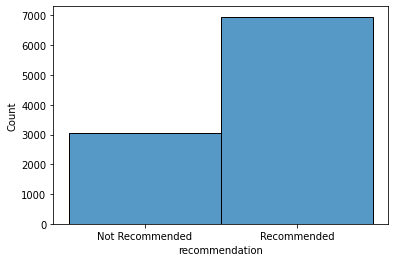

In [65]:
import numpy as np
import seaborn as sns

# Plot distribution of recommended and not recommended labels
print(steam_train['recommendation'].value_counts())
sns.histplot(steam_train, x='recommendation');

In [188]:
# Observe min and max words per review in each label
# Create num of words per review column
steam_train['n_words'] = steam_train['clean_text'].apply(lambda row: len(row))

def display_max_min_mean(df):
  max = df.groupby(by='recommendation')['n_words'].max()
  min = df.groupby(by='recommendation')['n_words'].min()
  mean = df.groupby(by='recommendation')['n_words'].mean()

  # Display Not Recommended stats
  print(f"Max number of words per review in \"Not Recommended\": {max[0]}",
        f"Min number of words per review in \"Not Recommended\": {min[0]}",
        f"Mean number of words per review in \"Not Recommended\": {round(mean[0])}",
        sep='\n')
  print('--'*80)

  # Display Recommended stats
  print(f"Max number of words per review in \"Recommended\": {max[1]}",
        f"Max number of words per review in \"Recommended\": {min[1]}",
        f"Mean number of words per review in \"Recommended\": {round(mean[1])}",
        sep='\n')

In [189]:
display_max_min_mean(steam_train)

Max number of words per review in "Not Recommended": 695
Min number of words per review in "Not Recommended": 0
Mean number of words per review in "Not Recommended": 27
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Max number of words per review in "Recommended": 768
Max number of words per review in "Recommended": 0
Mean number of words per review in "Recommended": 19


At this point, it looks like some of our reviews have actually been cleaned to the point where there is 0 words in them. Let's take a closer look at these instances.

In [190]:
steam_train[steam_train['n_words'] == 0].sample(5)

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,rec_labels,clean_text,n_words
336346,2018-09-24,0,0,251,False,Recommended,bestie 10/10,PLAYERUNKNOWN'S BATTLEGROUNDS,1,[],0
246630,2017-09-27,0,0,65,True,Recommended,8.9/10.,PLAYERUNKNOWN'S BATTLEGROUNDS,1,[],0
407276,2015-12-26,0,0,0,True,Recommended,gjhikolkjhikghikhojghohk,Rust,1,[],0
342079,2018-03-03,0,0,113,False,Recommended,REEEEEEEEEEEEEEEEEEEEEEEEEEE,PLAYERUNKNOWN'S BATTLEGROUNDS,1,[],0
173989,2017-06-23,0,0,100,False,Recommended,.,Grand Theft Auto V,1,[],0


The rows with a value of 0 in `n_words` appear to represent reviews that we wanted mostly filtered out (non-english, digits, etc.), which is what we wanted. Let's go ahead and removed these rows with 0 words in `clean_text`.

In [191]:
steam_train = steam_train[steam_train['n_words'] != 0 ]
display_max_min_mean(steam_train)

Max number of words per review in "Not Recommended": 695
Min number of words per review in "Not Recommended": 1
Mean number of words per review in "Not Recommended": 28
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Max number of words per review in "Recommended": 768
Max number of words per review in "Recommended": 1
Mean number of words per review in "Recommended": 20


Based on the Max and Mean number of words in each class, we can see that our data appears to be skewed and we could have "outliers" - that is, reviews with an unusually large number of words. These reviews are typically long because they go in depth with the specific game they are describing. This can become unnecessary information as describing what actually happens in the game does not necessarily dictate whether the reviewer actually enjoyed the game or not. Let's take a look at what our `n_words` columns looks like on a box and whisker plot. From there, we will take a closer look at these video game reviews.

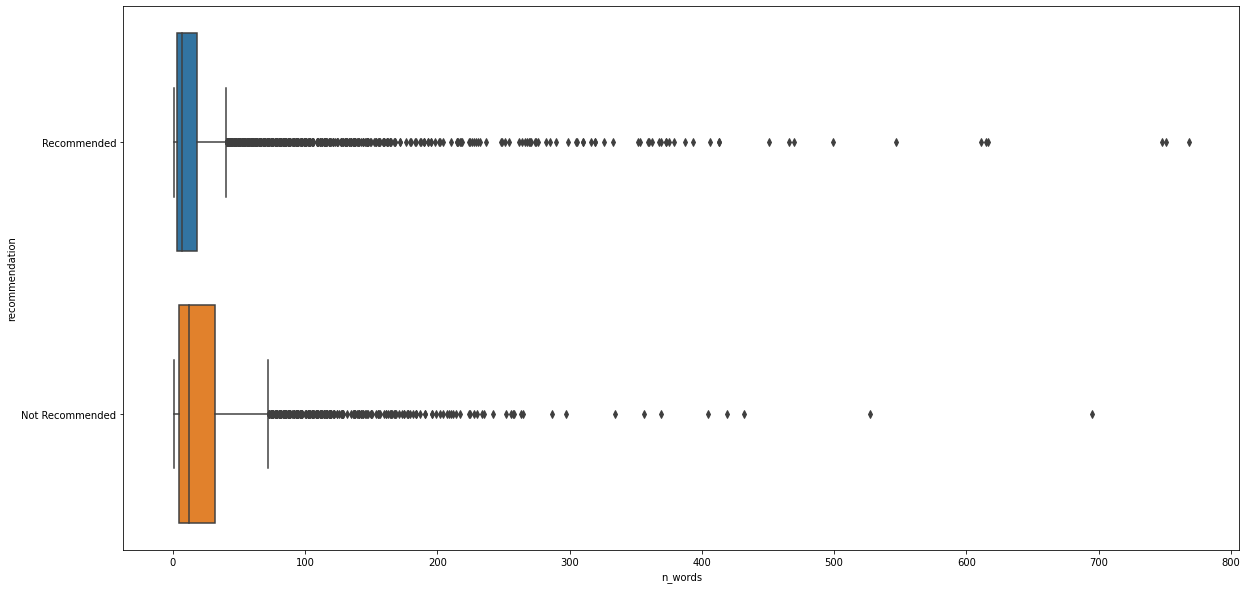

In [192]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
sns.boxplot(x=steam_train['n_words'], y=steam_train['recommendation'])

In [194]:
# Take a closer look at our outliers using our random sample function
random_sample(steam_train[steam_train['n_words'] > 200])

************************************************************************************************************************
RECOMMENDATION:
Not Recommended
------------------------------------------------------------------------------------------------------------------------
REVIEW:
I love PUBG it is by far the most fun and realistic battle royal I have ever played. That being said the DEVs lack any care for fixing this game. To list a few very simple fixes Parachuting is still broken I have landed thousands of times and I cannot begin to the frustration of still being kicked off the roof of a building and taking fall damage because it is STILL BROKEN. The same can be said about hitting trees or power lines still drops you every time at a decent height that does (while minor) damage. DESYNC holy cow is this atrocious now. Whatever you did DEVs to "fix" the game you've broken it more. I have been behind many many many buildings walls trees rocks anything and everything and still been shot

After taking a closer look, we chose to keep the reviews because although they contain a lot of fluff describing the game, they do so by using words that we believe would help a model decide whether or not a game is recommend. For example, "It's even worse for me because the game doesn't load at all for me and I have to close it from task manager start it again and reconnect.All of the above issues have been in the game for MONTHS and nothing has been done to fix or even address them. Don't waste your time and nerves on this game".

Moving on, let's look at the word frequencies in each class.

In [195]:
# Create function to create list of words
def flatten(column):
  "Returns list from list of lists"
  return [item for sublist in column for item in sublist]

In [196]:
import matplotlib.pyplot as plt

def plot_word_freq(df):
  """ This function takes a dataframe, divides the clean text into each class,
  and displays the most frequent words along with the unique number of words.
  """

  # Words in both classes
  words_in_recommended = flatten(df[df['recommendation'] == 'Recommended']['clean_text'])
  words_in_not_recommended = flatten(df[df['recommendation'] == 'Not Recommended']['clean_text'])

  # Frequency distributions
  freq_recommended = nltk.FreqDist(words_in_recommended)
  freq_not_recommended = nltk.FreqDist(words_in_not_recommended)

  print(f"Unique Words in Recommended: {len(freq_recommended.keys()) }")
  print(f"Unique Words in Recommended: {len(freq_not_recommended.keys()) }")

  # Display frequency distributions
  plt.figure(figsize=(10, 7))
  plt.title("Word Frequencies in Recommended")
  freq_recommended.plot(30, cumulative=False)

  plt.figure(figsize=(10, 7))
  plt.title("Word Frequencies in Not Recommended")
  freq_not_recommended.plot(30, cumulative=False)

Unique Words in Recommended: 8710
Unique Words in Recommended: 6980


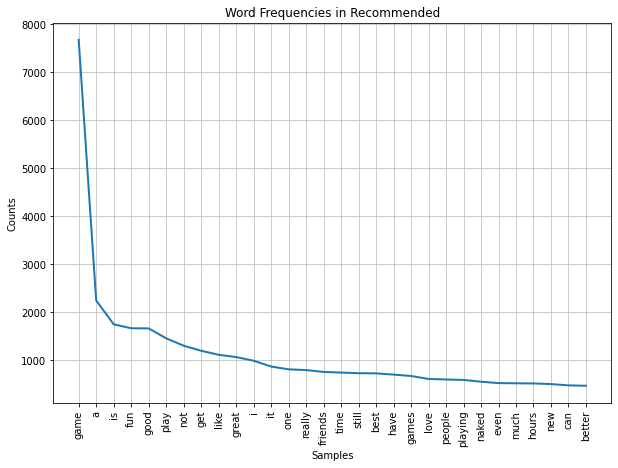

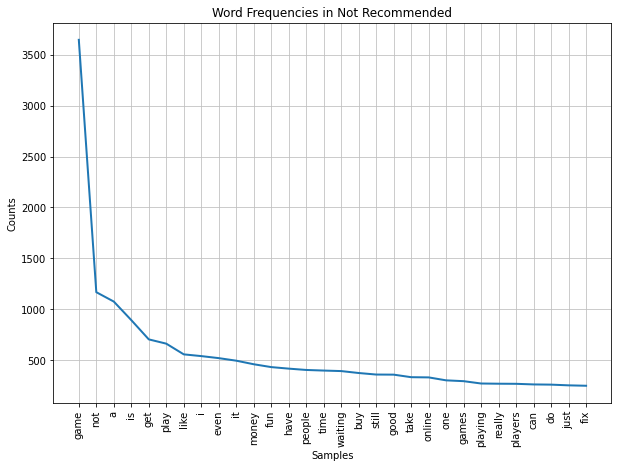

In [197]:
plot_word_freq(steam_train)

After taking a look at our word frequencies, there is an issue we need to address. The word "game" is mentioned the most in both reviews. Given that we are analyzing game reviews, this is obviously expected. However, we will opt out of including the word since "game" is mentioned in both classes the most.

In [198]:
def remove_word(review, word):
  return [w for w in review if w != word]


sample = ['hello', 'game', 'is', 'cool']

remove_word(sample, 'game')

['hello', 'is', 'cool']

In [199]:
# Remove "game" and "a" from both classes
steam_train['clean_text'] = steam_train['clean_text'].apply(lambda row: remove_word(row, 'game'))
steam_train['clean_text'] = steam_train['clean_text'].apply(lambda row: remove_word(row, 'a'))

In [200]:
def plot_horizontal_bar(df):
  # Words in both classes
  words_in_recommended = flatten(df[df['recommendation'] == 'Recommended']['clean_text'])
  words_in_not_recommended = flatten(df[df['recommendation'] == 'Not Recommended']['clean_text'])

  # Frequency distributions
  freq_recommended = nltk.FreqDist(words_in_recommended)
  freq_not_recommended = nltk.FreqDist(words_in_not_recommended)
  
  # Turn clean frequencies into series
  freq_recommended_series = pd.Series(dict(freq_recommended.most_common(10)))
  freq_not_recommended_series = pd.Series(dict(freq_not_recommended.most_common(10)))

  # Horizontal bar chart
  plt.figure(figsize=(10, 7))
  plt.title('Most common words in Recommended')
  sns.barplot(y=freq_recommended_series.index, x=freq_recommended_series.values)
  plt.xticks();

  # Horizontal bar chart
  plt.figure(figsize=(10, 7))
  plt.title("Most common words in Not Recommended")
  sns.barplot(y=freq_not_recommended_series.index, x=freq_not_recommended_series.values)
  plt.xticks();

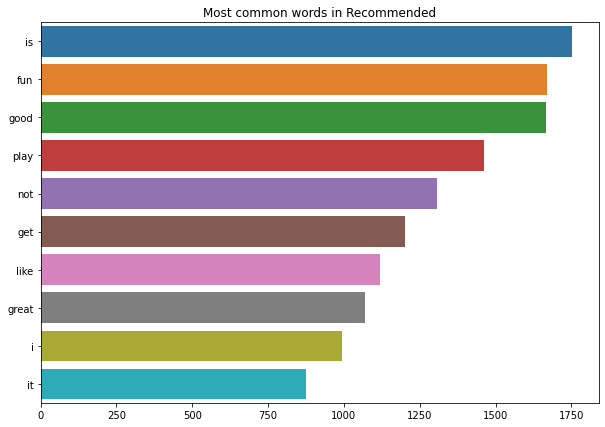

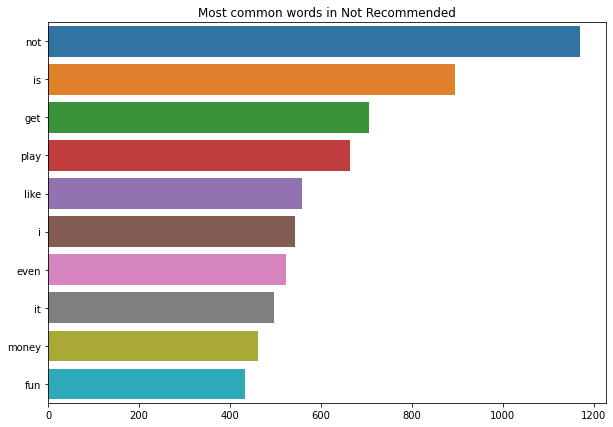

In [201]:
plot_horizontal_bar(steam_train)

In [202]:
from wordcloud import WordCloud

def word_cloud(df):
  # Words in both classes
  words_in_recommended = flatten(df[df['recommendation'] == 'Recommended']['clean_text'])
  words_in_not_recommended = flatten(df[df['recommendation'] == 'Not Recommended']['clean_text'])

  # Frequency distributions
  freq_recommended = nltk.FreqDist(words_in_recommended)
  freq_not_recommended = nltk.FreqDist(words_in_not_recommended)

  # Word Cloud
  plt.figure(figsize=(10,7))
  plt.title('Recommended', fontsize=20)
  wc = WordCloud(background_color="white", max_words=10).generate_from_frequencies(freq_recommended)
  plt.imshow(wc)
  plt.axis("off")

  # Word Cloud
  plt.figure(figsize=(10,7))
  plt.title('Not Recommended', fontsize=20)
  wc = WordCloud(background_color="white", max_words=10).generate_from_frequencies(freq_not_recommended)
  plt.imshow(wc)
  plt.axis("off");

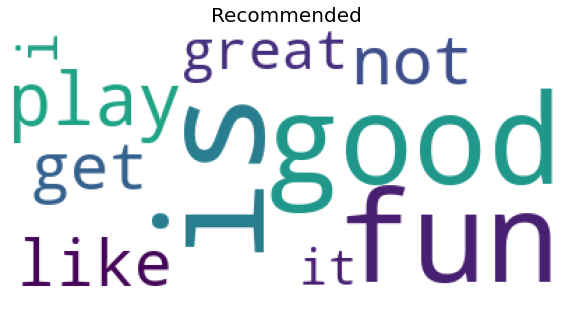

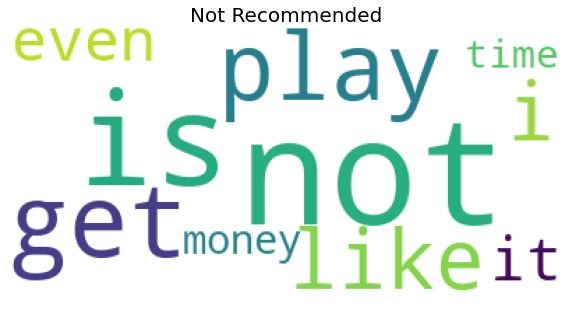

In [80]:
word_cloud(steam_train)

We are now done with our text analysis, let's go ahead and start building our models.

# Models

For our project, we are going to build 6 different models. We will perform cross validation for each model and hyper-parameter tuning. After choosing our best model, we will do a final evaluation using our test data. First we will start by creating the TF-IDF feature from our cleaned review data.

Here are the models we will be working with:

1. Naive Bayes
2. Linear SVM
3. Logistic Regression
4. Random Forest
5. Ensemble Learning
  1. Linear SVM, Logistic Regression, Random Forest - Hard Voting
  2. Naive Bayes, Logistic Regression, Random Forest - Soft Voting



In [208]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

# Our data is already tokenized, this function helps bypass sklearn's
def dummy(doc):
    return doc

# Create 
tf_idf_pipeline = Pipeline([
     ('vect', CountVectorizer(tokenizer=dummy, preprocessor=dummy, lowercase=False)),
     ('tfidf', TfidfTransformer())
 ])

# Create X and y
X_train, y_train = steam_train['clean_text'], steam_train['rec_labels']

# Transform X_train
X_train_tfidf = tf_idf_pipeline.fit_transform(X_train)

# Create train and validation sets
X_train_tfidf, X_val_tfidf, y_train, y_val = train_test_split(X_train_tfidf, y_train, test_size=0.2)

In [204]:
# This function is taken directly from Daniel Bourke's Tensorflow course on Udemy
# Here is the direct link https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
import itertools

# 1: Not Recommended, 0: Recommended
labels = {0:"Not Recommended", 1:"Recommended"}

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = [classes[i] for i in classes]
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

### Naive Bayes

In [83]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

nb_clf = MultinomialNB()

# Training with Default parameters
nb_clf_gs = GridSearchCV(nb_clf, param_grid={})

nb_clf_gs.fit(X_train_tfidf, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None, param_grid={},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

                 precision    recall  f1-score   support

Not Recommended       0.85      0.28      0.42       578
    Recommended       0.76      0.98      0.85      1326

       accuracy                           0.77      1904
      macro avg       0.81      0.63      0.63      1904
   weighted avg       0.79      0.77      0.72      1904



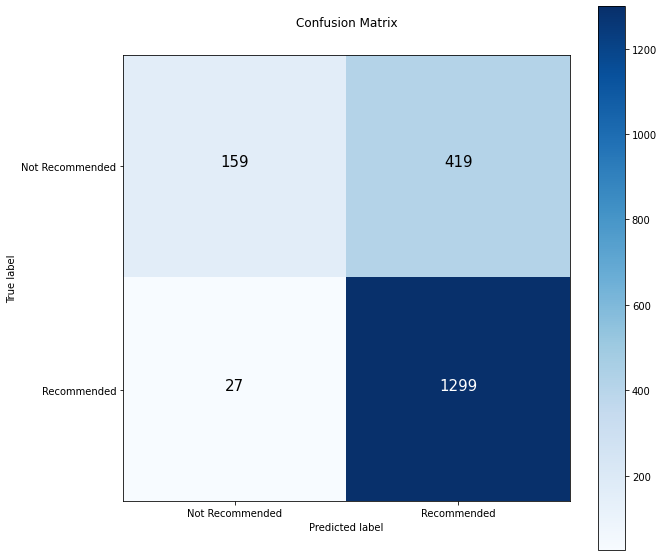

In [84]:
# Store predictions
y_preds = nb_clf_gs.predict(X_val_tfidf)

# Print classification report
print(classification_report(y_val, y_preds, target_names=['Not Recommended', 'Recommended']))

# Display confusion matrix
make_confusion_matrix(y_val, y_preds, classes=labels)

### Linear SVM

In [85]:
from sklearn.svm import LinearSVC

param_grid = {'C': np.logspace(-5, 5, 13) }

svm_clf = LinearSVC()

# Training with Default parameters
svm_clf_gs = GridSearchCV(svm_clf, param_grid=param_grid)

svm_clf_gs.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-05, 6.81292069e-05, 4.64158883e-04, 3.16227766e-03,
       2.15443469e-02, 1.46779927e-01, 1.00000000e+00, 6.81292069e+00,
       4.64158883e+01, 3.16227766e+02, 2.15443469e+03, 1.46779927e+04,
       1.00000000e+05])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

                 precision    recall  f1-score   support

Not Recommended       0.78      0.59      0.67       578
    Recommended       0.84      0.93      0.88      1326

       accuracy                           0.83      1904
      macro avg       0.81      0.76      0.78      1904
   weighted avg       0.82      0.83      0.82      1904



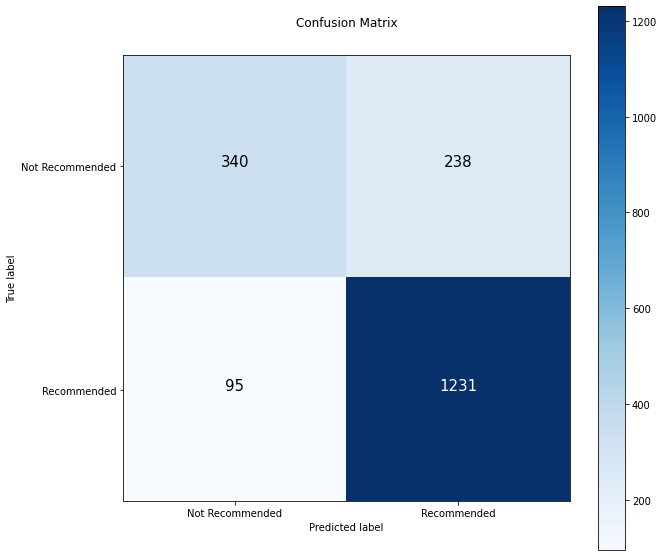

In [86]:
# Store predictions
y_preds = svm_clf_gs.predict(X_val_tfidf)

# Print classification report
print(classification_report(y_val, y_preds, target_names=['Not Recommended', 'Recommended']))

# Display confusion matrix
make_confusion_matrix(y_val, y_preds, classes=labels)

### Logistic Regression

In [87]:
from sklearn.linear_model import LogisticRegression

log_reg_clf = LogisticRegression()

param_grid = {'C':[100, 10, 1.0, 0.1, 0.01]}

# Training with Default parameters
log_reg_clf_gs = GridSearchCV(log_reg_clf, param_grid=param_grid)

log_reg_clf_gs.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

                 precision    recall  f1-score   support

Not Recommended       0.80      0.57      0.66       578
    Recommended       0.83      0.94      0.88      1326

       accuracy                           0.83      1904
      macro avg       0.81      0.75      0.77      1904
   weighted avg       0.82      0.83      0.82      1904



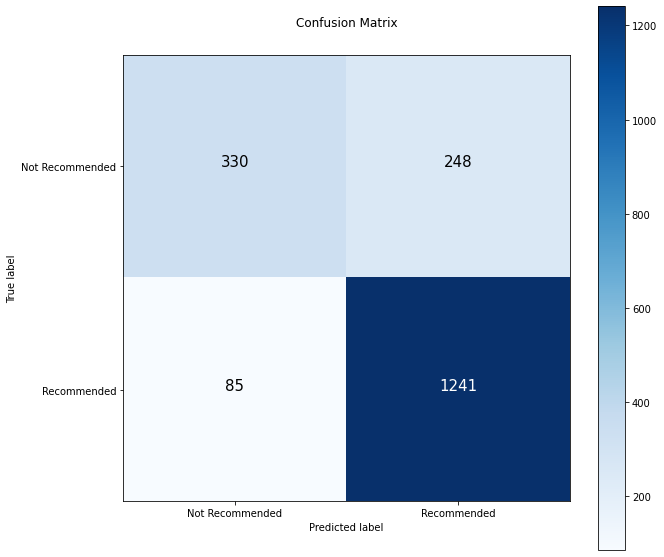

In [88]:
# Store predictions
y_preds = log_reg_clf_gs.predict(X_val_tfidf)

# Print classification report
print(classification_report(y_val, y_preds, target_names=['Not Recommended', 'Recommended']))

# Display confusion matrix
make_confusion_matrix(y_val, y_preds, classes=labels)

### Random Forest

In [89]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()

splits = [3, 5, 7, 9]

parameters = {'min_samples_split':splits}

forest_clf_gs = GridSearchCV(forest_clf, param_grid=parameters)

forest_clf_gs.fit(X_train_tfidf, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

                 precision    recall  f1-score   support

Not Recommended       0.76      0.55      0.64       578
    Recommended       0.83      0.92      0.87      1326

       accuracy                           0.81      1904
      macro avg       0.79      0.74      0.76      1904
   weighted avg       0.81      0.81      0.80      1904



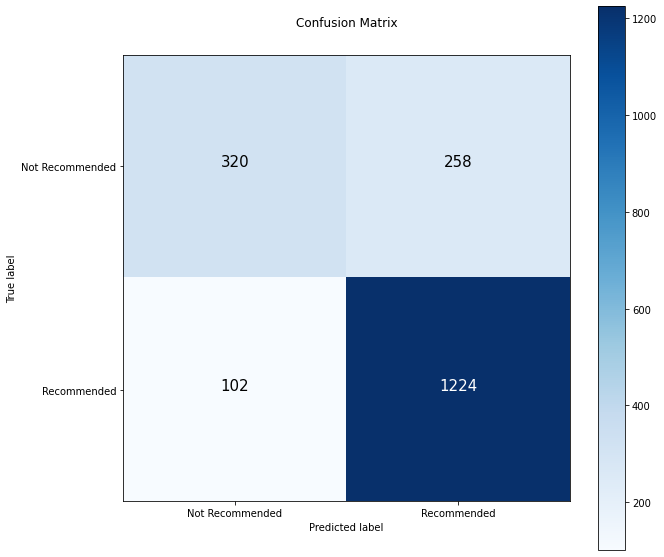

In [90]:
# Store predictions
y_preds = forest_clf_gs.predict(X_val_tfidf)

# Print classification report
print(classification_report(y_val, y_preds, target_names=['Not Recommended', 'Recommended']))

# Display confusion matrix
make_confusion_matrix(y_val, y_preds, classes=labels)

### Ensemble Learning (Linear SVC, Log Reg, Random Forest) - Hard Voting

For this ensemble, we will use the best parameters found from the previous grid searches. We perform hard voting given that our Linear SVC does not provide predicted probabilities.


In [214]:
from sklearn.ensemble import VotingClassifier

# Setup our estimators
estimators = [('svc', svm_clf_gs), ('log_reg', log_reg_clf_gs), ('forest_clf', forest_clf_gs)]

voting_clf = VotingClassifier(estimators=estimators, voting='hard')

# Fit the data
voting_clf.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sci

VotingClassifier(estimators=[('svc',
                              GridSearchCV(cv=None, error_score=nan,
                                           estimator=LinearSVC(C=1.0,
                                                               class_weight=None,
                                                               dual=True,
                                                               fit_intercept=True,
                                                               intercept_scaling=1,
                                                               loss='squared_hinge',
                                                               max_iter=1000,
                                                               multi_class='ovr',
                                                               penalty='l2',
                                                               random_state=None,
                                                               tol=0.0001,
                      

                 precision    recall  f1-score   support

Not Recommended       0.81      0.62      0.71       556
    Recommended       0.86      0.94      0.90      1350

       accuracy                           0.85      1906
      macro avg       0.84      0.78      0.80      1906
   weighted avg       0.85      0.85      0.84      1906



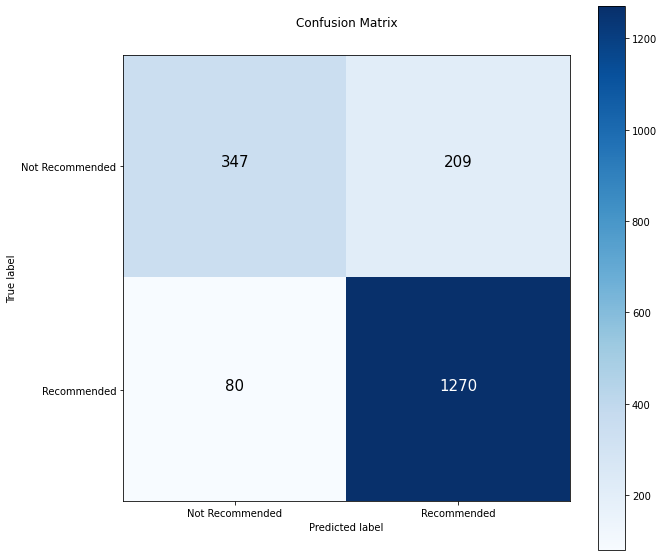

In [216]:
# Store predictions
y_preds = voting_clf.predict(X_val_tfidf)

# # Print classification report
print(classification_report(y_val, y_preds, target_names=['Not Recommended', 'Recommended']))

# # Display confusion matrix
make_confusion_matrix(y_val, y_preds, classes=labels)

### Ensemble Learning (Naive Bayes, Log Reg, Random Forest) - Soft Voting

For this ensemble, we will use the best parameters found from the previous grid searches like before. We perform soft voting this time since all of our estimator provide a predicted probability.


In [93]:
from sklearn.ensemble import VotingClassifier

# Setup our estimators
estimators = [('nb', nb_clf_gs), ('log_reg', log_reg_clf_gs), ('forest_clf', forest_clf_gs)]

voting_clf_2 = VotingClassifier(estimators=estimators, voting='soft')

# Fit the data
voting_clf_2.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


VotingClassifier(estimators=[('nb',
                              GridSearchCV(cv=None, error_score=nan,
                                           estimator=MultinomialNB(alpha=1.0,
                                                                   class_prior=None,
                                                                   fit_prior=True),
                                           iid='deprecated', n_jobs=None,
                                           param_grid={},
                                           pre_dispatch='2*n_jobs', refit=True,
                                           return_train_score=False,
                                           scoring=None, verbose=0)),
                             ('log_reg',
                              GridSearchCV(cv=None, error_score=nan,
                                           estimator=LogisticRegression(C=1.0,...
                                                                            min_samples_split=2,
        

                 precision    recall  f1-score   support

Not Recommended       0.80      0.46      0.58       578
    Recommended       0.80      0.95      0.87      1326

       accuracy                           0.80      1904
      macro avg       0.80      0.70      0.73      1904
   weighted avg       0.80      0.80      0.78      1904



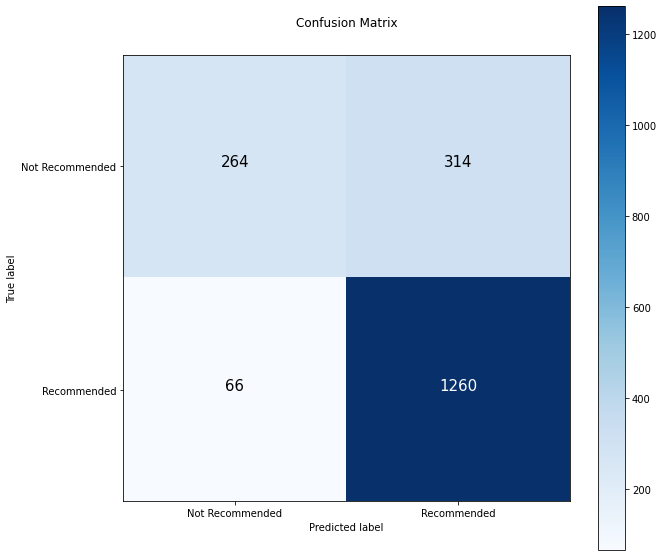

In [99]:
# Store predictions
y_preds = voting_clf_2.predict(X_val_tfidf)

# # Print classification report
print(classification_report(y_val, y_preds, target_names=['Not Recommended', 'Recommended']))

# # Display confusion matrix
make_confusion_matrix(y_val, y_preds, classes=labels)

## Final Model Evaluation

It seems like our ensemble model didn't give as much of a boost as we had hoped for. Our second model did not perform as well given we switched out our Linear SVC for Naive Baye's in order to use soft voting. After looking at our F1 scores, Accuracy, Average, and Weighted Average, it's clear that our first ensemble came out on top ever so slightly. As such, we will use it as our final model and evaluate it on our final test set.

In [217]:
# Create pipeline to clean test data
def pipeline(df):
  # Perform inital text preprocessing
  df['clean_text'] = df['review'].apply(lambda row: clean_text(str(row)))
  
  # Create n_words column
  df['n_words'] = df['clean_text'].apply(lambda row: len(row))

  # Filter out reviews that have been completely removed
  df = df[df['n_words'] != 0 ]

  # Create  label encoding
  df['rec_labels'] = df["recommendation"].astype('category').cat.codes

  # Remove "game" from both classes
  df['clean_text'] = df['clean_text'].apply(lambda row: remove_word(row, 'game'))
  df['clean_text'] = df['clean_text'].apply(lambda row: remove_word(row, 'a'))
  
  df.reset_index(inplace=True)

  return df

# Create subset
steam_test = steam_test.sample(1000)

# Clean test subset
steam_test_cleaned = pipeline(steam_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [218]:
# Create X and y
X_test, y_test = steam_test_cleaned['clean_text'], steam_test_cleaned['rec_labels']

# Transform X_test
X_test_tfidf = tf_idf_pipeline.transform(X_test)

                 precision    recall  f1-score   support

Not Recommended       0.81      0.57      0.67       325
    Recommended       0.81      0.93      0.87       630

       accuracy                           0.81       955
      macro avg       0.81      0.75      0.77       955
   weighted avg       0.81      0.81      0.80       955



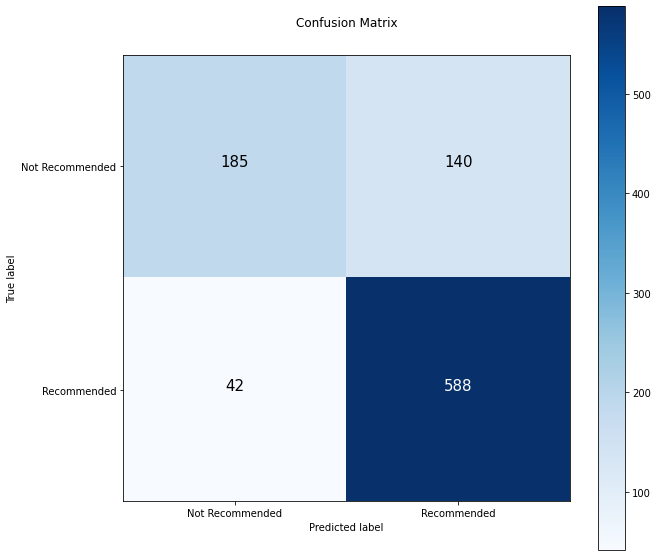

In [219]:
# Store predictions
y_preds = voting_clf.predict(X_test_tfidf)

# # Print classification report
print(classification_report(y_test, y_preds, target_names=['Not Recommended', 'Recommended']))

# # Display confusion matrix
make_confusion_matrix(y_test, y_preds, classes=labels)

Our final model performed well overall, really close to our validation score! Although the F1-score was slightly low for our `Not Recommended` class, the model was able to perform up to par compared to our training scores. We will be using this model for the "Text Classification" Component of our final project.

### Demo

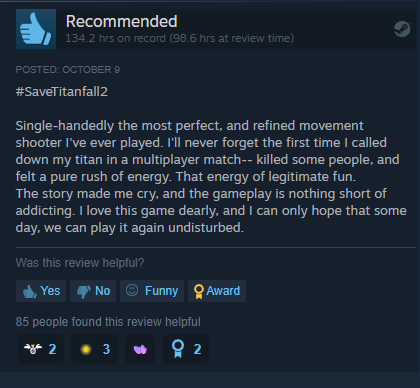

In [223]:
example_review = """Single-handedly the most perfect, and refined movement shooter I've ever played. I'll never forget the first time I called down my titan in a multiplayer match-- killed some people, and felt a pure rush of energy. That energy of legitimate fun.
The story made me cry, and the gameplay is nothing short of addicting. I love this game dearly, and I can only hope that some day, we can play it again undisturbed."""

example_review_cleaned = clean_text(example_review)

example_review_cleaned

['perfect',
 'refined',
 'movement',
 'shooter',
 'ever',
 'played',
 'ill',
 'never',
 'forget',
 'first',
 'time',
 'called',
 'titan',
 'match',
 'killed',
 'people',
 'felt',
 'a',
 'pure',
 'rush',
 'energy',
 'energy',
 'legitimate',
 'fun',
 'story',
 'made',
 'cry',
 'nothing',
 'short',
 'addicting',
 'love',
 'game',
 'dearly',
 'hope',
 'day',
 'can',
 'play',
 'again',
 'undisturbed']

In [224]:
# Label:  Recommended (1)
example_review_cleaned = np.array(example_review_cleaned).reshape(1, -1)
# print(example_review_cleaned)

exampled_review_tfidf = tf_idf_pipeline.transform(example_review_cleaned)
exampled_review_tfidf.shape

(1, 10777)

In [225]:
prediction = voting_clf.predict(exampled_review_tfidf)[0]
print(f"Based on this review, the game is {labels[prediction]}!")

Based on this review, the game is Recommended!


# Resources:
* EDA on Text Data / Custom function to expand contractions: https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

* TF-IDF Text Classification:
https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

* Voting Classifiers:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

* Sklearn Documentaton:
https://scikit-learn.org/stable/

* Customed Confusion Matrix (from Daniel Bourke):
https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

* Models chosen based on this Paper:
http://cs229.stanford.edu/proj2017/final-reports/5244171.pdf